# Explore Data

_by Alex Berndt_
_12 Dec 2021_

__Abstract__

This notebook serves as the starting point for this investigation. We aim to get a _feel_ for the provided data by:

1. Visualization
2. Interpretation

## Install Dependencies

In [1]:
from collections import namedtuple, OrderedDict
import os

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from pathlib import Path

%matplotlib inline

from helper import (
    read_json, 
    get_metadata_path,
    get_udm_file_path,
    get_udm2_file_path,
    get_tif_file_path,
    get_COG_file_path,
)

# Define core repository directories
ROOT_DIR = Path(os.getcwd()).parents[2]
ASSETS_DIR = os.path.join(ROOT_DIR, "assets/")

In [2]:
# Define item id's saved in `./assets/` dir
item_ids = [
    '20210425_100412_ssc3_u0001',
    '20210425_100412_ssc3_u0002',
    '20210528_131522_ssc9_u0001',
    '20210710_133141_ssc8_u0001',
    '20210922_100732_ssc12_u0001',
    '20210922_100732_ssc12_u0002',
]

item_type = 'PSScene4Band'

In [3]:
# store the scene filename for processing and make sure the file exists
scene_filename = get_tif_file_path(item_ids[0])

print(scene_filename)
assert os.path.isfile(scene_filename)

/home/alex/github_repos/ml-notebooks/assets/20210425_100412_ssc3_u0001/files/SkySatCollect/20210425_100412_ssc3_u0001/pansharpened_udm2/20210425_100412_ssc3_u0001_pansharpened.tif


In [4]:
# Utility functions: loading an image

NamedBands = namedtuple('NamedBands', 'b, g, r, nir')

def load_masked_bands(filename):
    """Loads a 4-band BGRNir Planet Image file as a list of masked bands.
    
    The masked bands share the same mask, so editing one band mask will
    edit them all."""
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
    
    bands = NamedBands(b=b, g=g, r=r, nir=nir)
    return NamedBands(*[np.ma.array(b, mask=mask)
                        for b in bands])

print(load_masked_bands(scene_filename).b.shape)

(45562, 14731)


In [5]:
# Utility functions: displaying an image

def _linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min)*(new_max - new_min)/(old_max - old_min) + new_min

def _mask_to_alpha(bands):
    band = np.atleast_3d(bands)[...,0]
    alpha = np.zeros_like(band)
    alpha[~band.mask] = 1
    return alpha

def _add_alpha_mask(bands):
    return np.dstack([bands, _mask_to_alpha(bands)])

def bands_to_display(bands, alpha=True):
    """Converts a list of bands to a 3-band rgb, normalized array for display."""
    rgb_bands = np.dstack(bands[:3])

    old_min = np.percentile(rgb_bands, 2)
    old_max = np.percentile(rgb_bands, 98)
    new_min = 0
    new_max = 1
    scaled = _linear_scale(rgb_bands.astype(np.double),
                           old_min, old_max, new_min, new_max)
    bands = np.clip(scaled, new_min, new_max)
    if alpha is True:
        bands = _add_alpha_mask(bands)
    return bands

In [8]:
### MEMORY RUNS OUT
# fig = plt.figure(figsize=(10, 10))
# bands = load_masked_bands(scene_filename)
# plt.imshow(bands_to_display([bands.r, bands.g, bands.b]))

# plt.title('Scene')
# ax = plt.axis('off')

In [9]:
# store the udm2 filename for processing and make sure the file exists
udm2_filename = get_udm2_file_path(item_ids[0])
print(udm2_filename)
assert os.path.isfile(udm2_filename)

/home/alex/github_repos/ml-notebooks/assets/20210425_100412_ssc3_u0001/files/SkySatCollect/20210425_100412_ssc3_u0001/pansharpened_udm2/20210425_100412_ssc3_u0001_pansharpened_udm2.tif


In [10]:
# Utility functions for loading a UDM2 image and identify bands as
# class labels
def load_udm2(udm2_filename):
    '''Load multi-band UDM2 as a 3d array.'''
    with rasterio.open(udm2_filename, 'r') as src:
        udm2 = src.read()
    return udm2

udm2_labels = ['clear', 'snow', 'shadow', 'light haze', 'heavy haze', 'cloud',
               'confidence', 'unusable pixels']

udm2 = load_udm2(udm2_filename)
print(udm2.shape)
print(udm2_labels)

(8, 45562, 14731)
['clear', 'snow', 'shadow', 'light haze', 'heavy haze', 'cloud', 'confidence', 'unusable pixels']


In [11]:
num_pixels = np.size(udm2[0,:])
num_clear = np.count_nonzero(udm2[0,:])
            
percent_clear = 100 * (num_pixels - num_clear) / num_pixels
print("{0:.01f}% of pixels are considered 'clear'".format(percent_clear))

27.9% of pixels are considered 'clear'


/tmp/ipykernel_7927/1571936114.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)


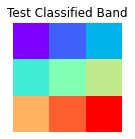

In [12]:
def plot_classified_band(class_band, class_labels=None,
                         cmap='rainbow',
                         title='Class Labels', figdim=10):

    fig = plt.figure(figsize=(figdim, figdim))
    ax = fig.add_subplot(1, 1, 1)
    imshow_class_band(ax, class_band, class_labels=class_labels, cmap=cmap)
    ax.set_title(title)
    ax.set_axis_off()

def imshow_class_band(ax, class_band, class_labels=None, cmap='rainbow'):
    """Show classified band with colormap normalization and color legend.
    Alters ax in place.
    
    possible cmaps ref:
    https://matplotlib.org/examples/color/colormaps_reference.html
    """
    class_norm = _ClassNormalize(class_band)
    im = ax.imshow(class_band, cmap=cmap, norm=class_norm)

    try:
        # add class label legend
        # https://stackoverflow.com/questions/25482876
        # /how-to-add-legend-to-imshow-in-matplotlib
        color_mapping = class_norm.mapping
        colors = [im.cmap(color_mapping[k])
                  for k in class_labels.keys()]
        labels = class_labels.values()

        # https://matplotlib.org/users/legend_guide.html
        # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
        patches = [mpatches.Patch(color=c, label=l)
                   for c,l in zip(colors, labels)]

        ax.legend(handles=patches, bbox_to_anchor=(1, 1),
                  loc='upper right', borderaxespad=0.)
    except AttributeError:
        # class_labels not specified
        pass

# Inspired by
# https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
class _ClassNormalize(colors.Normalize):
    """Matplotlib colormap normalizer for a classified band.
    """
    def __init__(self, arry):
        # get unique unmasked values
        values = [v for v in np.unique(arry)
                  if not isinstance(v, np.ma.core.MaskedConstant)]

        # map unique values to points in the range 0-1
        if len(values) > 1:
            color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)
        else:
            color_ticks = np.array([0])

        self._mapping = dict((v, ct) for v, ct in zip(values, color_ticks))
        
        # Initialize base Normalize instance
        vmin = 0
        vmax = 1
        clip = False
        colors.Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, arry, clip=None):
        '''Create classified representation of arry for display.'''
        # round array back to ints for logical comparison
        arry = np.around(arry)
        new_arry = arry.copy()
        for k, v in self._mapping.items():
            new_arry[arry==k] = v
        return new_arry
    
    @property
    def mapping(self):
        '''property required for colors.Normalize classes
        
        We update the _mapping property in __init__ and __call__ and just
        return that property here.
        '''
        return self._mapping
    
# test out classified band visualization
test_classified_band = np.array(range(9)).reshape((3,3))
plot_classified_band(test_classified_band, title='Test Classified Band',
                     figdim=2)

/tmp/ipykernel_7927/1571936114.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)


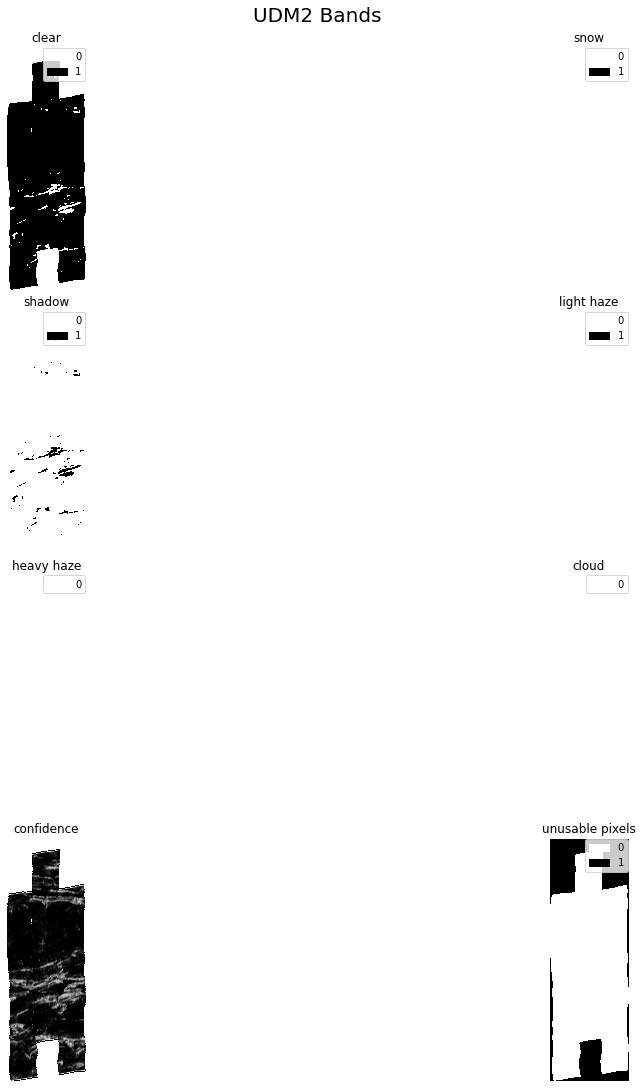

In [13]:
def visualize_udm2(udm2, figsize=(15,15)):
    fig, axes = plt.subplots(nrows=4, ncols=2,
                                   sharex=True, sharey=True,
                                   figsize=figsize,
                            constrained_layout=True)
    
    bands = [np.squeeze(b) for b in 
             np.split(udm2, udm2.shape[0], axis=0)]
    band_labels = udm2_labels

    fig.suptitle('UDM2 Bands', fontsize=20)
    bal = zip(bands, axes.flat, udm2_labels)
    for i, (band, ax, label) in enumerate(bal):
        unique = np.unique(band)
    
        # it is unwieldy to show a legend for more than 5 values
        if len(unique) < 5:
            class_labels = OrderedDict((v, v) for v in np.unique(band))
        else:
            class_labels = None
        imshow_class_band(ax, band, class_labels=class_labels, cmap='Greys')
        ax.set_title(label)
        ax.set_axis_off()

visualize_udm2(udm2)

In [14]:
def get_udm_labels(udm):
    '''Get the interpretation of the UDM binary values'''    
    def get_label(v):
        if v == 0:
            label = 'clear'
        elif v == 1:
            label = 'blackfill'
        else:
            labels = []
            if v & int('10',2):
                labels.append('cloud')
            if v & int('1111100',2):
                bands = []
                if v & int('100',2):
                    bands.append('Blue')
                if v & int('1000', 2):
                    bands.append('Green')
                if v & int('10000', 2):
                    bands.append('Red')
                if v & int('100000', 2):
                    bands.append('Red-Edge')
                if v & int('1000000', 2):
                    bands.append('NIR')
                labels.append('missing/suspect {} data'.format(', '.join(bands)))
                
            if not len(labels):
                labels.append('{0:08b}'.format(v))

            label = ', '.join(labels)
        return label

    return OrderedDict((v, get_label(v)) for v in np.unique(udm))

udm2_udm = udm2[-1, ...]
print('Labels present in this UDM2 UDM band')
get_udm_labels(udm2_udm)

Labels present in this UDM2 UDM band


OrderedDict([(0, 'clear'), (1, 'blackfill')])

/tmp/ipykernel_7927/1571936114.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)


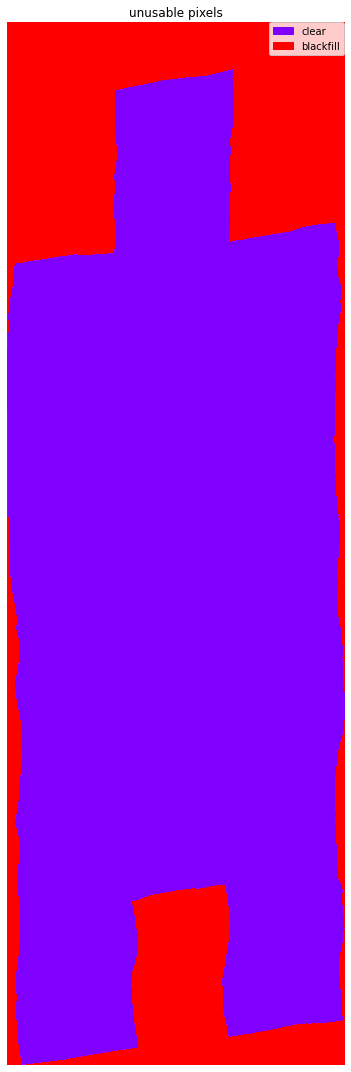

In [15]:
def visualize_udm2_unusable(udm2, figsize=(15,15)):
    '''Visualize the unusable data mask band of the UDM2 product.'''
    fig, ax = plt.subplots(nrows=1, ncols=1,
                                   sharex=True, sharey=True,
                                   figsize=figsize)
    band = udm2[-1, :]
    label = udm2_labels[-1]

    imshow_class_band(ax, band, class_labels=get_udm_labels(band), cmap='rainbow')
    ax.set_title(label)
    ax.set_axis_off()

    plt.tight_layout()

visualize_udm2_unusable(udm2)

In [16]:
mask_class_labels = {0: 'unmasked', 1: 'masked'}
mask_cmap = 'viridis' # looks better when just two colors are displayed

/tmp/ipykernel_7927/1571936114.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)


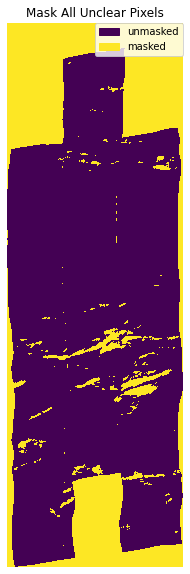

In [17]:
def mask_unclear(udm2_array):
    '''Create a mask from the udm2, masking all unclear pixels''' 
    return udm2_array[0,...] == 0

plot_classified_band(mask_unclear(udm2),
                     class_labels=mask_class_labels,
                     cmap=mask_cmap,
                     title='Mask All Unclear Pixels')

/tmp/ipykernel_7927/1571936114.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)


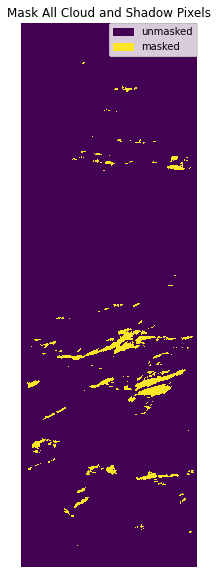

In [18]:
def mask_cloud_shadow(udm2_array):
    '''Create a mask from the udm2, masking all cloud and cloud shadow pixels'''
    shadow_band = udm2_array[2,...]
    cloud_band = udm2_array[5,...]
    masked_pixels = np.logical_or(shadow_band == 1, cloud_band == 1)
    return masked_pixels

plot_classified_band(mask_cloud_shadow(udm2),
                     class_labels=mask_class_labels,
                     cmap=mask_cmap,
                     title='Mask All Cloud and Shadow Pixels')